# Notebook for using a moist energy balance model to study SRM scenarios

## 1. Setup model

In [1]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import scipy.special as ss
from scipy.integrate import odeint
from scipy.interpolate import interp1d

In [2]:
###############################
# Model parameters

l = 360 #number of grid-points from equator to pole
sin_lat = np.linspace( -1., 1., l ) #x = sin latitude 
dx = sin_lat[1] - sin_lat[0]
lat = np.arcsin( sin_lat ) * 180. / np.pi #latitude
cos_lat = np.sqrt( 1. - sin_lat ** 2 )

Q = 1360. #solar constant
L = 2.5 * 10. ** 6 #latent heat of vaporization
rh = 0.8 #assume a fixed relative humidity
cp = 1005 #heat capacity of air

gamma = 0.482 #for calculating the insolation structure function
P2 = 1. / 2. * ( 3 * sin_lat ** 2 - 1) #second Legendre polynomial

#albedo parameters w/ice-albedo feedback
a0 = 0.32 #open water albedo
a1 = 0.62 #sea ice albedo
T0 = 262.15 
ht = 6. #thickness parameter

#co-albedo parameters w/o ice-albedo feedback
al_0 = 0.68 
al_1 = -0.2 
co_al_0 = al_0 + al_1 * P2 #co-albedo

S = 1. - gamma * P2 #insolation structure function

insolation_0 = 1. / 4. * Q * S #insolation profile 
S1 = 180. #amplitude of seasonal cycle

#Feedback co-efficients:
A = -290.
B = 1.8

cw = 9.8 #heat capacity of mixed layer
D = 0.25 #diffusivity

In [3]:
###############################
# Model functions

def calc_qs( T ):
    #Calculate saturation mixing ratio

    #first calculate saturation vapor pressure using the August-Roche-Magnus approximation
    qsat = 0.61094 * np.exp( 17.625 * (T - 273.15) / ( (T - 273.15) + 243.04) ) * 1000.
    #convert to mixing ratio
    return 0.622 * qsat / (1000. * 100. - qsat)

def int_albedo( T ):
    #Interactive albedo
    return (a0 + a1) / 2. + (a0 - a1) / 2. * np.tanh( (T - T0) / ht)

def calc_rhs_albedo( T, time, F = 0, alb = 0, seas = 0, reduc = 0, presc_reduction = 0, frac_reduction = 0 ):
    """
    RHS of model.
    T = initial guess of temperature
    time = integration time
    F = CO2 forcing
    al = interactive ice-albedo feedback
    seas = whether to do seasons
    reduc = whether to do geoengineering
    presc_reduction = prescribed insolation reduction
    frac_reduction = fractional insolation reduction

    """

    #First the easy part: calculate the feedback
    feedback = A + B * T 

    #Calculate insolation and albedo
    if alb == 1:
        al = 1. - int_albedo( T )
    else:
        al = co_al_0 
        
    if seas == 1:
        insolation = insolation_0 - S1 * sin_lat * np.cos( time * 2. * np.pi)
    else:
        insolation = insolation_0 

    #Now do some geoengineering
    if reduc == 1: #fractional insolation reduction
        ins = (1. - frac_reduction) * insolation * al 
    elif reduc == 2: #prescribed insolation reduction
            ins = (insolation - presc_reduction) * al 
    else: #no geoengineering
        ins = insolation * al 

    #zero out where have negative insolation
    for k in range( len(ins)):
        if ins[k] < 0.:
            ins[k] = 0.

    #Now the diffusivity:
    qs = calc_qs( T ) #calculate saturation mixing ratio
    h =  T + L * rh * qs / cp #calculate mse / cp

    diffusion = np.zeros(l) # = D(1 - x^2)d^2h/dx^2 - 2Dxdh/dx
    #use second-order scheme to calculate Laplacian
    for i in range(1, l - 1 ):
        diffusion[i] = (D / dx**2) * (1. - sin_lat[i]**2) * (h[i+1] - 2 * h[i] + h[i-1]) - (D * sin_lat[i] / dx) * (h[i+1] - h[i-1])
    diffusion[0] = -D * 2 * sin_lat[0] * (h[1] - h[0]) / dx
    diffusion[-1] = -D * 2 * sin_lat[-1] * (h[-1] - h[-2]) / dx  
    
    #Bring everything together and divide by cw
    return (ins - feedback + diffusion + F) / cw


###############################
# Plotting stuff

# These are the "Tableau 20" colors as RGB.    
cs = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(cs)):    
    r, g, b = cs[i]    
    cs[i] = (r / 255., g / 255., b / 255.)  

def make_axis( ax ):

	ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
	ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction ='out')                                                                                          

	ax.tick_params(length = 6, which = 'major')
	ax.tick_params(length = 4, which = 'minor')

	#ax.spines["top"].set_visible(False)    
	#ax.spines["right"].set_visible(False)      

	majorLocator = MultipleLocator( 30 )
	majorFormatter = FormatStrFormatter('%d')
	minorLocator = MultipleLocator( 10 )

	ax.xaxis.set_major_locator(majorLocator)
	ax.xaxis.set_major_formatter(majorFormatter)
	ax.xaxis.set_minor_locator(minorLocator)
	plt.xlabel( "Latitude", fontsize = 14)
	plt.xlim([-90., 90.])   
                                                             
	return ax


# 2. Control simulation

In [4]:
#Now do calculations
Ti = np.ones( l ) * 280. #initial guess
time = np.linspace(0., 100., 1000) 

sol = odeint(calc_rhs_albedo, Ti, time, args = (0, 1, 1)) # solve

con_seas = sol[955:965]
con_seas = np.swapaxes( con_seas, 0, 1)

con = np.mean(sol[-10:], axis = 0) - 273.15

print np.trapz( con * cos_lat, lat * np.pi / 180.) / 2. #global-mean temperature
print max(con) - min(con) #equator-to-pole temperature difference

15.301287161107894
40.45181610114406


In [5]:
forcing = np.loadtxt("forcing.dat")
f = interp1d( forcing[:, 0], forcing[:, 1] )

nforcing = np.zeros( l)
nforcing[1:l-1] = f(lat[1:l-1])
nforcing[0] = forcing[0, 1]
nforcing[-1] = forcing[-1, 1]

print np.trapz( nforcing * cos_lat, lat * np.pi / 180.) / 2.

2.207677849481954


In [6]:
#Now do P - E
p_e = np.load("MERRA_P_E.dat")
p_e = p_e[:] 
lat3 = np.linspace(-90., 90., len(p_e)) #MERRA has uniform grid-spacing

f = interp1d( lat3, p_e )
np_e = f(lat)

alpha = 0.07

/home/nick/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:84: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


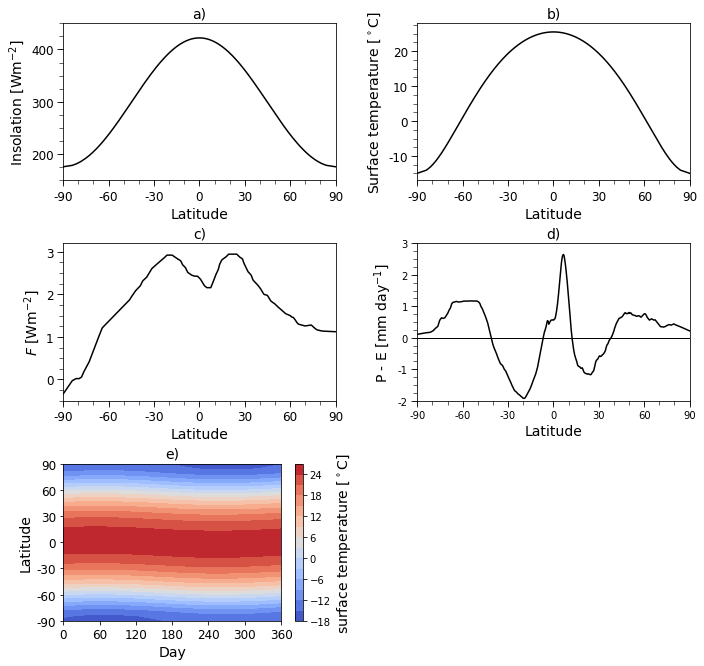

In [7]:
fig = plt.figure( figsize = (10, 10) )
plt.subplots_adjust(left = 0.08, right = 0.95, bottom = 0.12, top = 0.95, wspace = 0.3, hspace = 0.4)


ax = plt.subplot(3, 2, 1)
plt.title("a)", fontsize = 14)

plt.plot( lat, insolation_0, 'k')

make_axis( ax )

majorLocator = MultipleLocator( 100 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 25 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "Insolation [Wm$^{-2}$]", fontsize = 14)
plt.ylim([150., 450.])   

plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
    
ax = plt.subplot(3, 2, 2)
plt.title("b)", fontsize = 14)

plt.plot( lat, con, 'k')

make_axis( ax )

majorLocator = MultipleLocator( 10 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 2.5 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "Surface temperature [$^\circ$C]", fontsize = 14)
plt.ylim([-17., 28.]) 

plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

ax = plt.subplot(3, 2, 3)
plt.title("c)", fontsize = 14)

plt.plot( lat, nforcing, 'k')

make_axis( ax )

majorLocator = MultipleLocator( 1 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( .25 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$F$ [Wm$^{-2}$]", fontsize = 14)
plt.ylim([-0.5, 3.2]) 

plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

ax = plt.subplot(3, 2, 4)
plt.title( "d)", fontsize = 14)

plt.plot( lat, np_e, color = 'k')

make_axis( ax )

majorLocator = MultipleLocator( 1 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( .25 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "P - E [mm day$^{-1}$]", fontsize = 14)
plt.ylim([-2., 3.])   
plt.axhline( y = 0, color = 'k', linewidth = 1.)


year = np.linspace(0., 360, 10.)
ax = plt.subplot(3, 2, 5)
plt.title("e)", fontsize = 14)

#seas = np.swapaxes(seas, 0, 1)
v = np.arange(-18., 30., 3.)
plt.contourf( year, lat, con_seas - 273.15, v, cmap = plt.cm.coolwarm )
cb = plt.colorbar(ticks = [-18, -12, -6., 0., 6., 12., 18., 24.])
cb.set_label("surface temperature [$^\circ$C]", fontsize = 14)

majorLocator = MultipleLocator( 30 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 2.5 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
#ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "Latitude", fontsize = 14)
plt.ylim([-90., 90.]) 

majorLocator = MultipleLocator( 60 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 2.5 )

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
#ax.yaxis.set_minor_locator(minorLocator)
plt.xlabel( "Day", fontsize = 14)
plt.xlim([0., 360.]) 

plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

plt.savefig("control_climate.pdf")
plt.show()

# 3. Global warming simulation

In [8]:
#Now do GW case
sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing, 1, 1 ) ) #GW
GW = np.mean(sol[-10:], axis = 0 )  - 273.15

GW_seas = sol[950:960]
GW_seas = np.swapaxes( GW_seas, 0, 1)

resp_GW = GW - con

print np.trapz( resp_GW * cos_lat, lat * np.pi / 180.) / 2.

1.9228241166165085


# 4. Strong SRM scenarios

In [9]:
#Perfect SRM
Ti = np.ones( l ) * 280. #initial guess
al = 1. - int_albedo( con + 273.15 )
perf_red = np.ones( l ) * nforcing / al
sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing, 1, 1, 2, perf_red)) 
uni_opt = np.mean(sol[-10:], axis = 0 )  - 273.15
resp_opt = uni_opt - con

perf_seas = sol[950:960]
perf_seas = np.swapaxes( perf_seas, 0, 1)

print np.trapz( resp_opt * cos_lat, lat * np.pi / 180.) / 2.

0.0025273559821141654


In [10]:
#Uniform reduction
uniform_reduction = np.trapz( perf_red * cos_lat, lat * np.pi / 180.) / 2.
#uniform_reduction = 0.009 * np.trapz( insolation_0 * cos_lat, lat * np.pi / 180.) / 2.


sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing, 1, 1, 2, uniform_reduction)) 
uni_r = np.mean( sol[-100:], axis = 0 )  - 273.15
resp_uni = uni_r - con

uni_seas = sol[950:960]
uni_seas = np.swapaxes( uni_seas, 0, 1)

print np.trapz( resp_uni * cos_lat, lat * np.pi / 180.) / 2.

-0.2099580653907998


In [11]:
#fractional reduction
percent = uniform_reduction / (np.trapz( insolation_0 * cos_lat, lat * np.pi / 180.) / 2.)
print percent * 100.

sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing, 1, 1, 1, 0, percent))
uni_1 = np.mean(sol[-100:], axis = 0 )  - 273.15
resp_1 = uni_1 - con

frac_seas = sol[950:960]
frac_seas = np.swapaxes( frac_seas, 0, 1)

print np.trapz( resp_1 * cos_lat, lat * np.pi / 180.) / 2.

0.9607754359449595
-0.03683068225070119


In [12]:
#Arctic reduction
arctic_reduction = uniform_reduction * (1. + np.tanh( (lat - 70.) / 4.  ) )

sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing, 1, 1, 2, arctic_reduction)) 
uni_ar = np.mean( sol[-100:], axis = 0 )  - 273.15
resp_ar = uni_ar - con

ar_seas = sol[950:960]
ar_seas = np.swapaxes( ar_seas, 0, 1)

print np.trapz( resp_ar * cos_lat, lat * np.pi / 180.) / 2.

1.780220770054973


In [13]:
def calc_mse_diffusion( T ):
    l = len( T)
    
    qs = calc_qs( T ) #calculate saturation mixing ratio
    h =  T + L * rh * qs / cp #calculate mse / cp

    diffusion = np.zeros(l) # = D(1 - x^2)d^2h/dx^2 - 2Dxdh/dx
    #use second-order scheme to calculate Laplacian
    for i in range(1, l - 1 ):
        diffusion[i] = (D / dx**2) * (1. - sin_lat[i]**2) * (h[i+1] - 2 * h[i] + h[i-1]) - (D * sin_lat[i] / dx) * (h[i+1] - h[i-1])
    diffusion[0] = D * 2 * (h[1] - h[0]) / dx**2
    diffusion[-1] = -D * 2 * sin_lat[-1] * (h[-1] - h[-2]) / dx
    
    trans = np.zeros( l )
    for i in range(1, l - 1 ):
        trans[i] = D * (1. - sin_lat[i]**2) * (h[i+1] - h[i-1]) / 2. / dx
    
    return h, diffusion, trans

In [14]:
con_h, con_diff, con_trans = calc_mse_diffusion( con + 273.15 )

gw_h, gw_diff, gw_trans = calc_mse_diffusion( con + resp_GW + 273.15 )
op_h, op_diff, op_trans = calc_mse_diffusion( con + resp_1 + 273.15 )
uni_h, uni_diff, uni_trans = calc_mse_diffusion( con + resp_uni + 273.15 )
perf_h, perf_diff, perf_trans = calc_mse_diffusion( con + resp_opt + 273.15 )
ar_h, ar_diff, ar_trans = calc_mse_diffusion( con + resp_ar + 273.15 )

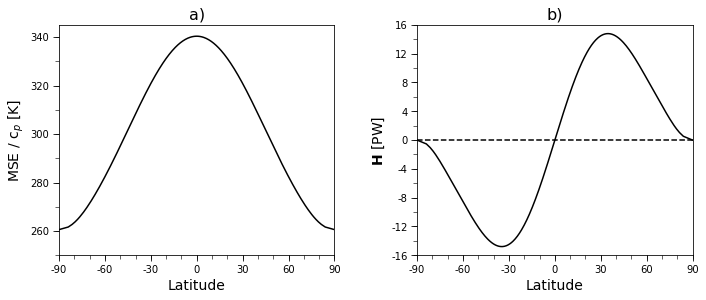

In [15]:
#Plot control climate
fig = plt.figure( figsize = (10, 4) )
plt.subplots_adjust(left = 0.07, right = 0.95, bottom = 0.13, top = 0.93, wspace = 0.3, hspace = 0.4)

ax = plt.subplot(1, 2, 1)
plt.title("a)", fontsize = 16)

plt.plot( lat, con_h, 'k')

majorLocator = MultipleLocator( 20 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 10 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "MSE / c$_p$ [K]", fontsize = 14)
plt.ylim([250., 345.])   

make_axis( ax )

ax = plt.subplot(1, 2, 2)
plt.title("b)", fontsize = 16)

plt.plot( lat, -con_trans, 'k')
majorLocator = MultipleLocator( 4 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 2 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\mathbf{H}$ [PW]", fontsize = 14)
plt.ylim([-16., 16.])

plt.axhline( y = 0, color = 'k', linestyle = '--')

make_axis( ax )

plt.savefig("control_energy_transport.pdf")
plt.show()

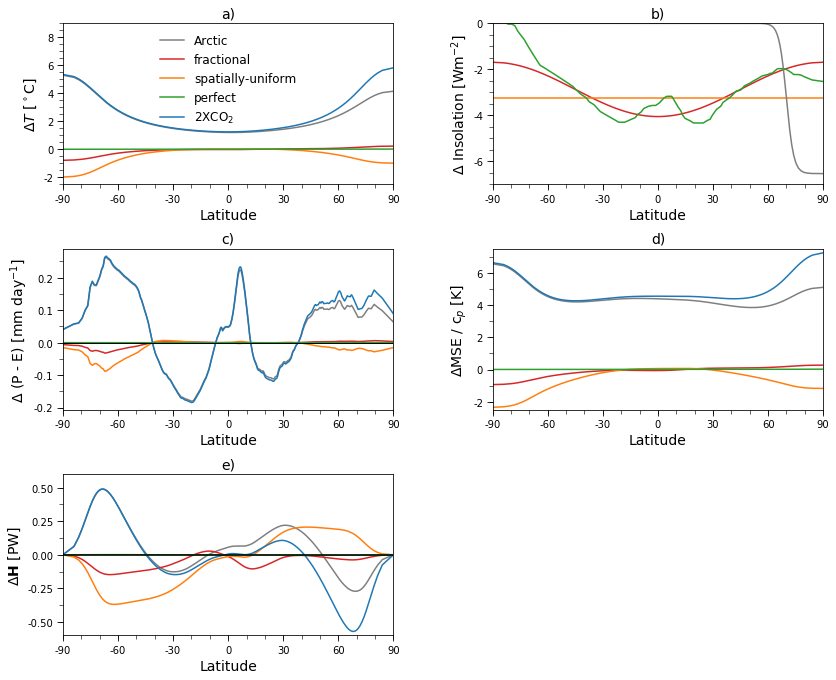

In [16]:
fig = plt.figure( figsize = (12, 10) )
plt.subplots_adjust(left = 0.07, right = 0.95, bottom = 0.1, top = 0.95, wspace = 0.3, hspace = 0.4)


ax = plt.subplot(3, 2, 1)
plt.title("a)", fontsize = 14)

plt.plot( lat, resp_ar, color = cs[14])
plt.plot( lat, resp_1, color = cs[6])
plt.plot( lat, resp_uni, color = cs[2])
plt.plot( lat, resp_opt, color = cs[4])
plt.plot( lat, resp_GW, color = cs[0])

make_axis( ax )

majorLocator = MultipleLocator( 2 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( .5 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta T$ [$^\circ$C]", fontsize = 14)
plt.ylim([-2.5, 9.])

plt.legend(["Arctic", "fractional", "spatially-uniform", "perfect", "2XCO$_2$"], fontsize = 12, loc = "upper center", frameon = False)

ax = plt.subplot(3, 2, 2)
plt.title("b)", fontsize = 14)


plt.plot( lat, -percent * insolation_0, color = cs[6])
plt.plot( lat, -uniform_reduction * np.ones( l), color = cs[2])
arctic = (1. + np.tanh( (lat - 70.) / 4.  ) )
plt.plot( lat, -uniform_reduction * arctic , color = cs[14])
plt.plot( lat, -perf_red , color = cs[4])

make_axis( ax )

majorLocator = MultipleLocator( 2 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( .5 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$ Insolation [Wm$^{-2}$]", fontsize = 14)
plt.ylim([-7., 0.])

ax = plt.subplot(3, 2, 3)
plt.title("c)", fontsize = 14)

plt.plot( lat, alpha * resp_1 * np_e, color = cs[6])
plt.plot( lat, alpha * resp_uni * np_e, color = cs[2])
plt.plot( lat, alpha * resp_ar * np_e, color = cs[14])
plt.plot( lat, alpha * resp_opt * np_e, color = cs[4])
plt.plot( lat, alpha * resp_GW * np_e, color = cs[0])

make_axis( ax )

majorLocator = MultipleLocator( .1 )
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator( .05 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$ (P - E) [mm day$^{-1}$]", fontsize = 14)
#plt.ylim([-.3, .3])   
plt.axhline( y = 0, color = 'k', linewidth = 1.)

ax = plt.subplot(3, 2, 4)
plt.title("d)", fontsize = 14)

plt.plot( lat, ar_h - con_h, color = cs[14])
plt.plot( lat, op_h - con_h, color = cs[6])
plt.plot( lat, uni_h - con_h, color = cs[2])
plt.plot( lat, perf_h - con_h, color = cs[4])
plt.plot( lat, gw_h - con_h, color = cs[0])

majorLocator = MultipleLocator( 2 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 1 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$MSE / c$_p$ [K]", fontsize = 14)
plt.ylim([-2.5, 7.5])   

make_axis( ax )

ax = plt.subplot(3, 2, 5)
plt.title("e)", fontsize = 14)

plt.plot( lat, -ar_trans + con_trans, color = cs[14])
plt.plot( lat, -op_trans + con_trans, color = cs[6])
plt.plot( lat, -uni_trans + con_trans, color = cs[2])
plt.plot( lat, -perf_trans + con_trans, color = cs[4])
plt.plot( lat, -gw_trans + con_trans, color = cs[0])

majorLocator = MultipleLocator( 0.25 )
majorFormatter = FormatStrFormatter('%0.2f')
minorLocator = MultipleLocator( 0.125 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta\mathbf{H}$ [PW]", fontsize = 14)
plt.ylim([-0.6, 0.6])

plt.axhline( y = 0, color = 'k')

make_axis( ax )

plt.savefig("common_geoengineering_proposals.pdf")
plt.show()

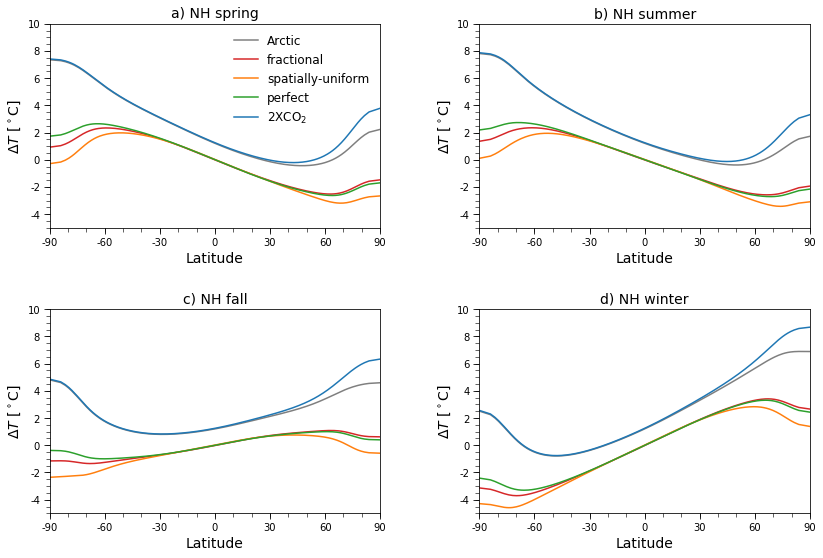

In [17]:
#Seasonal responses
fig = plt.figure( figsize = (12, 8) )
plt.subplots_adjust(left = 0.07, right = 0.95, bottom = 0.1, top = 0.95, wspace = 0.3, hspace = 0.4)

titles = ["a) NH spring", "b) NH summer", "c) NH fall", "d) NH winter"]

for j in range( 4 ):
    ax = plt.subplot(2, 2, j + 1)
    plt.title( titles[j], fontsize = 14)

    con_s = np.mean( con_seas[:, j * 2:(j + 1) * 2], axis = 1 )
    
    plt.plot( lat, np.mean( ar_seas[:, j * 2:(j + 1) * 2], axis = 1 ) - con_s, color = cs[14])
    plt.plot( lat, np.mean( frac_seas[:, j * 2:(j + 1) * 2], axis = 1 ) - con_s, color = cs[6])
    plt.plot( lat, np.mean( uni_seas[:, j * 2:(j + 1) * 2], axis = 1 ) - con_s, color = cs[2])
    plt.plot( lat, np.mean( perf_seas[:, j * 2:(j + 1) * 2], axis = 1 ) - con_s, color = cs[4])
    plt.plot( lat, np.mean( GW_seas[:, j * 2:(j + 1) * 2], axis = 1 ) - con_s, color = cs[0])

    make_axis( ax )

    majorLocator = MultipleLocator( 2 )
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator( .5 )

    ax.yaxis.set_major_locator(majorLocator)
    ax.yaxis.set_major_formatter(majorFormatter)
    ax.yaxis.set_minor_locator(minorLocator)
    plt.ylabel( "$\Delta T$ [$^\circ$C]", fontsize = 14)
    plt.ylim([-5., 10.])

    if j == 0:
        plt.legend(["Arctic", "fractional", "spatially-uniform", "perfect", "2XCO$_2$"], fontsize = 12, loc = "upper right", frameon = False)


plt.savefig("seasonal_responses.pdf")

# 5. Moderate SRM scenarios

In [18]:
#Perfect SRM
Ti = np.ones( l ) * 280. #initial guess
al = 1. - int_albedo( con + 273.15 )
perf_red2 = np.ones( l ) * nforcing / al * 0.5
sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing, 1, 1, 2, perf_red2)) 
uni_opt2 = np.mean(sol[-10:], axis = 0 )  - 273.15
resp_opt2 = uni_opt2 - con

perf_seas2 = sol[950:960]
perf_seas2 = np.swapaxes( perf_seas2, 0, 1)

print np.trapz( resp_opt2 * cos_lat, lat * np.pi / 180.) / 2.

1.0881765950414304


In [19]:
#Uniform reduction
uniform_reduction2 = np.trapz( perf_red2 * cos_lat, lat * np.pi / 180.) / 2.
#uniform_reduction = 0.009 * np.trapz( insolation_0 * cos_lat, lat * np.pi / 180.) / 2.


sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing, 1, 1, 2, uniform_reduction2)) 
uni_r2 = np.mean( sol[-100:], axis = 0 )  - 273.15
resp_uni2 = uni_r2 - con

uni_seas2 = sol[950:960]
uni_seas2 = np.swapaxes( uni_seas2, 0, 1)

print np.trapz( resp_uni2 * cos_lat, lat * np.pi / 180.) / 2.

1.0334078784942797


In [20]:
#fractional reduction
percent2 = uniform_reduction2 / (np.trapz( insolation_0 * cos_lat, lat * np.pi / 180.) / 2.)
print percent2 * 100.

sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing, 1, 1, 1, 0, percent2))
uni_12 = np.mean(sol[-100:], axis = 0 )  - 273.15
resp_12 = uni_12 - con

frac_seas2 = sol[950:960]
frac_seas2 = np.swapaxes( frac_seas2, 0, 1)

print np.trapz( resp_12 * cos_lat, lat * np.pi / 180.) / 2.

0.48038771797247976
1.0775484821750352


In [21]:
#Arctic reduction
arctic_reduction2 = uniform_reduction2 * (1. + np.tanh( (lat - 70.) / 4.  ) ) 

sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing, 1, 1, 2, arctic_reduction2)) 
uni_ar2 = np.mean( sol[-100:], axis = 0 )  - 273.15
resp_ar2 = uni_ar2 - con

ar_seas2 = sol[950:960]
ar_seas2 = np.swapaxes( ar_seas2, 0, 1)

print np.trapz( resp_ar2 * cos_lat, lat * np.pi / 180.) / 2.

1.8542292550830917


In [22]:
con_h, con_diff, con_trans = calc_mse_diffusion( con + 273.15 )
gw_h, gw_diff, gw_trans = calc_mse_diffusion( con + resp_GW + 273.15 )

op_h2, op_diff2, op_trans2 = calc_mse_diffusion( con + resp_12 + 273.15 )
uni_h2, uni_diff2, uni_trans2 = calc_mse_diffusion( con + resp_uni2 + 273.15 )
perf_h2, perf_diff2, perf_trans2 = calc_mse_diffusion( con + resp_opt2 + 273.15 )
ar_h2, ar_diff2, ar_trans2 = calc_mse_diffusion( con + resp_ar2 + 273.15 )

In [23]:
#Make even more effective moderate SRM profile
#polar-amplified reduction
polar_reduction = uniform_reduction2 * (2. + np.tanh( (abs(lat) - 70.) / 10.  ) * 1.5 ) / 2.
polar_reduction += uniform_reduction2 * (1. + np.tanh( (abs(lat) - 80.) / 5.  ) ) / 2.

ncos = np.zeros( l)
for i in range( l ):
    if abs(lat[i]) < 45.:
        ncos[i] = np.cos( lat[i] * 2. * np.pi / 180.) 
polar_reduction += ncos
polar_reduction *= uniform_reduction2 / np.trapz( polar_reduction * cos_lat, lat * np.pi / 180.) * 2.

sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing, 1, 1, 2, polar_reduction)) 
uni_pol = np.mean( sol[-100:], axis = 0 )  - 273.15
resp_pol = uni_pol - con

pol_seas = sol[950:960]
pol_seas = np.swapaxes( pol_seas, 0, 1)

print np.trapz( resp_pol * cos_lat, lat * np.pi / 180.) / 2.

pol_h, pol_diff, pol_trans = calc_mse_diffusion( con + resp_pol + 273.15 )

0.995603639300753


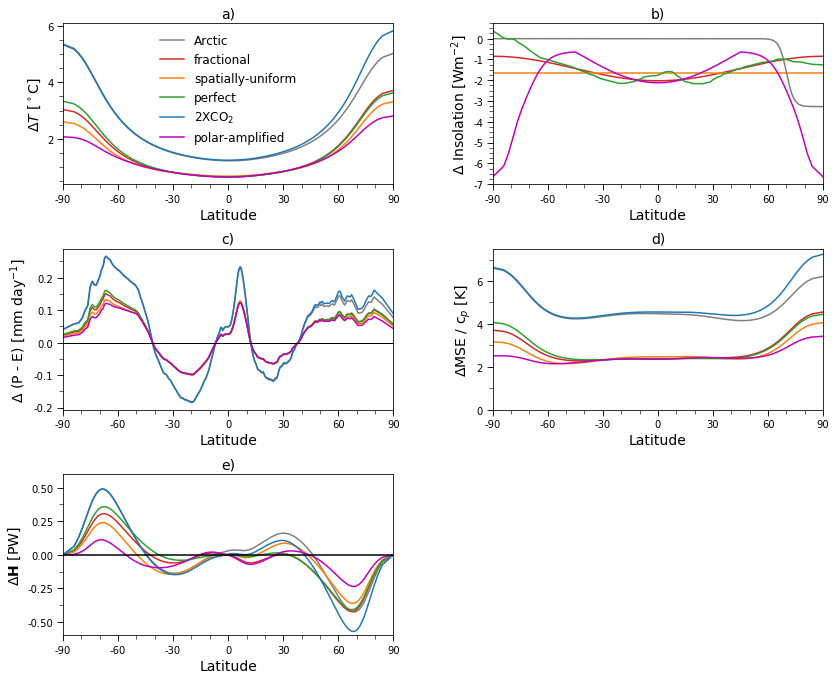

In [25]:
fig = plt.figure( figsize = (12, 10) )
plt.subplots_adjust(left = 0.07, right = 0.95, bottom = 0.1, top = 0.95, wspace = 0.3, hspace = 0.4)


ax = plt.subplot(3, 2, 1)
plt.title("a)", fontsize = 14)

plt.plot( lat, resp_ar2, color = cs[14])
plt.plot( lat, resp_12, color = cs[6])
plt.plot( lat, resp_uni2, color = cs[2])
plt.plot( lat, resp_opt2, color = cs[4])
plt.plot( lat, resp_GW, color = cs[0])
plt.plot( lat, resp_pol, color = 'm')

make_axis( ax )

majorLocator = MultipleLocator( 2 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( .5 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta T$ [$^\circ$C]", fontsize = 14)
#plt.ylim([0., 6.])

plt.legend(["Arctic", "fractional", "spatially-uniform",  "perfect", "2XCO$_2$", "polar-amplified"], fontsize = 12, loc = "upper center", frameon = False)

ax = plt.subplot(3, 2, 2)
plt.title("b)", fontsize = 14)


plt.plot( lat, -percent2 * insolation_0, color = cs[6])
plt.plot( lat, -uniform_reduction2 * np.ones( l), color = cs[2])
arctic = (1. + np.tanh( (lat - 70.) / 4.  ) ) 
plt.plot( lat, -uniform_reduction2 * arctic , color = cs[14])
plt.plot( lat, -perf_red2 , color = cs[4])
plt.plot( lat, -polar_reduction , color = 'm')

make_axis( ax )

majorLocator = MultipleLocator( 1 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( .25 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$ Insolation [Wm$^{-2}$]", fontsize = 14)
#plt.ylim([-2.5, 0.])

ax = plt.subplot(3, 2, 3)
plt.title("c)", fontsize = 14)

plt.plot( lat, alpha * resp_12 * np_e, color = cs[6])
plt.plot( lat, alpha * resp_uni2 * np_e, color = cs[2])
plt.plot( lat, alpha * resp_ar2 * np_e, color = cs[14])
plt.plot( lat, alpha * resp_opt2 * np_e, color = cs[4])
plt.plot( lat, alpha * resp_GW * np_e, color = cs[0])
plt.plot( lat, alpha * resp_pol * np_e, color = 'm')

make_axis( ax )

majorLocator = MultipleLocator( .1 )
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator( .05 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$ (P - E) [mm day$^{-1}$]", fontsize = 14)
#plt.ylim([-.3, .3])   
plt.axhline( y = 0, color = 'k', linewidth = 1.)

ax = plt.subplot(3, 2, 4)
plt.title("d)", fontsize = 14)

plt.plot( lat, ar_h2 - con_h, color = cs[14])
plt.plot( lat, op_h2 - con_h, color = cs[6])
plt.plot( lat, uni_h2 - con_h, color = cs[2])
plt.plot( lat, perf_h2 - con_h, color = cs[4])
plt.plot( lat, gw_h - con_h, color = cs[0])
plt.plot( lat, pol_h - con_h, color = 'm')

majorLocator = MultipleLocator( 2 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 1 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$MSE / c$_p$ [K]", fontsize = 14)
plt.ylim([0., 7.5])   

make_axis( ax )

ax = plt.subplot(3, 2, 5)
plt.title("e)", fontsize = 14)

plt.plot( lat, -ar_trans2 + con_trans, color = cs[14])
plt.plot( lat, -op_trans2 + con_trans, color = cs[6])
plt.plot( lat, -uni_trans2 + con_trans, color = cs[2])
plt.plot( lat, -perf_trans2 + con_trans, color = cs[4])
plt.plot( lat, -gw_trans + con_trans, color = cs[0])
plt.plot( lat, -pol_trans + con_trans, color = 'm')

majorLocator = MultipleLocator( 0.25 )
majorFormatter = FormatStrFormatter('%0.2f')
minorLocator = MultipleLocator( 0.125 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta\mathbf{H}$ [PW]", fontsize = 14)
plt.ylim([-0.6, 0.6])

plt.axhline( y = 0, color = 'k')

make_axis( ax )

plt.savefig("common_geoengineering_proposals_half.pdf")
plt.show()

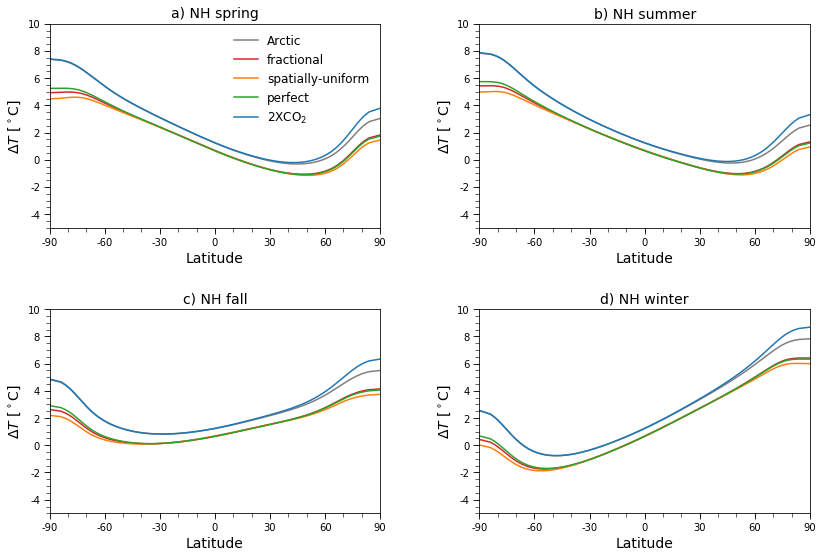

In [26]:
#Seasonal responses
fig = plt.figure( figsize = (12, 8) )
plt.subplots_adjust(left = 0.07, right = 0.95, bottom = 0.1, top = 0.95, wspace = 0.3, hspace = 0.4)

titles = ["a) NH spring", "b) NH summer", "c) NH fall", "d) NH winter"]

for j in range( 4 ):
    ax = plt.subplot(2, 2, j + 1)
    plt.title( titles[j], fontsize = 14)

    con_s = np.mean( con_seas[:, j * 2:(j + 1) * 2], axis = 1 )
    
    plt.plot( lat, np.mean( ar_seas2[:, j * 2:(j + 1) * 2], axis = 1 ) - con_s, color = cs[14])
    plt.plot( lat, np.mean( frac_seas2[:, j * 2:(j + 1) * 2], axis = 1 ) - con_s, color = cs[6])
    plt.plot( lat, np.mean( uni_seas2[:, j * 2:(j + 1) * 2], axis = 1 ) - con_s, color = cs[2])
    plt.plot( lat, np.mean( perf_seas2[:, j * 2:(j + 1) * 2], axis = 1 ) - con_s, color = cs[4])
    plt.plot( lat, np.mean( GW_seas[:, j * 2:(j + 1) * 2], axis = 1 ) - con_s, color = cs[0])

    make_axis( ax )

    majorLocator = MultipleLocator( 2 )
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator( .5 )

    ax.yaxis.set_major_locator(majorLocator)
    ax.yaxis.set_major_formatter(majorFormatter)
    ax.yaxis.set_minor_locator(minorLocator)
    plt.ylabel( "$\Delta T$ [$^\circ$C]", fontsize = 14)
    plt.ylim([-5., 10.])

    if j == 0:
        plt.legend(["Arctic", "fractional", "spatially-uniform", "perfect", "2XCO$_2$"], fontsize = 12, loc = "upper right", frameon = False)


plt.savefig("seasonal_responses_half.pdf")

# 6. Transient Calculations

In [71]:
#First do a transient "1%" simulation
F = np.linspace(0., 1., 71)
Ti = con + 273.15 #Start with control state

time = np.arange( 0., 1.1, .1) #Every year
sols = np.zeros( ( (71, len(time), l))) #Keep solutions every year

for i in range( 71 ):
    if i % 10 == 0:
        print "F = ", F[i]
    
    sols[i] = odeint(calc_rhs_albedo, Ti, time, args = (F[i] * nforcing, 1, 1 )) 
    Ti = sols[i, -1] #Initial state is end of previous year

F =  0.0
F =  0.14285714285714285
F =  0.2857142857142857
F =  0.42857142857142855
F =  0.5714285714285714
F =  0.7142857142857143
F =  0.8571428571428571
F =  1.0


In [79]:
#Perfect SRM branching simulations
lims = [10, 20, 30, 40, 50, 60, 70] #Years to start from
li = len( lims)
time = np.linspace(0., 200., 1000) #Integrate for 100 years

al = 1. - int_albedo( con + 273.15 ) #For calculating perfect reduction
#srm_scen = np.zeros( ( li, 1000)) #For storing annual-mean temperature change

for d in range( 2, li ):
    print "doing: ", lims[d]
    Ti = np.mean( sols[lims[d]], axis = 0) #initial condition
    red = np.ones( l ) * nforcing * F[lims[d]] / al
    sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing * F[lims[d]], 1, 1, 2, red ) ) 
    sol -= 273.15 + con
    srm_scen[d] = np.trapz( sol * cos_lat[np.newaxis, :], lat * np.pi / 180., axis = 1) / 2.

doing:  30
doing:  40
doing:  50
doing:  60
doing:  70


In [ ]:
#Fractional branching simulations
frac_scen = np.zeros( ( li, 1000)) #For storing annual-mean temperature change

for d in range( li ):
    print "doing: ", lims[d]
    Ti = np.mean( sols[lims[d]], axis = 0) #initial condition
    red = np.ones( l ) * nforcing * F[lims[d]] / al #Perfect SRM
    ur = np.trapz( red * cos_lat, lat * np.pi / 180.) / 2.
    percentage = ur / (np.trapz( insolation_0 * cos_lat, lat * np.pi / 180.) / 2.)
    sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing * F[lims[d]], 1, 1, 1, 0, percentage ) ) 
    sol -= 273.15 + con
    frac_scen[d] = np.trapz( sol * cos_lat[np.newaxis, :], lat * np.pi / 180., axis = 1) / 2.

In [84]:
#Spatially-uniform branching simulations
spat_scen = np.zeros( ( li, 1000)) #For storing annual-mean temperature change

for d in range( li ):
    print "doing: ", lims[d]
    Ti = np.mean( sols[lims[d]], axis = 0) #initial condition
    red = np.ones( l ) * nforcing * F[lims[d]] / al #Perfect SRM
    ur = np.trapz( red * cos_lat, lat * np.pi / 180.) / 2.
    sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing * F[lims[d]], 1, 1, 2, ur ) ) 
    sol -= 273.15 + con
    spat_scen[d] = np.trapz( sol * cos_lat[np.newaxis, :], lat * np.pi / 180., axis = 1) / 2.

doing:  10
doing:  20
doing:  30
doing:  40
doing:  50
doing:  60
doing:  70


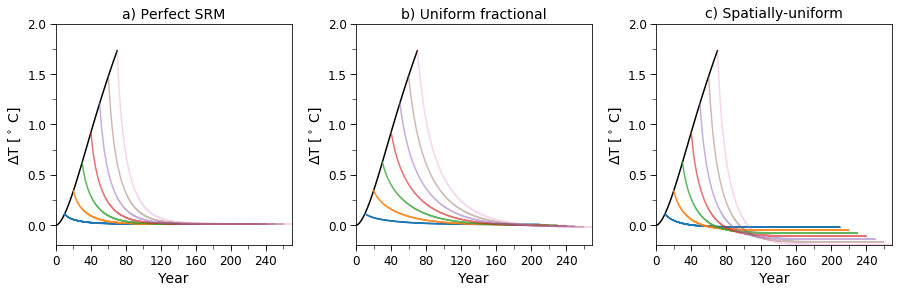

In [104]:
#For plotting the forced part
time = np.arange( 0., 71, 1)
forced = np.trapz( np.mean(sols, axis = 1) * cos_lat[np.newaxis, :], lat * np.pi / 180., axis = 1) / 2.
forced -= 273.15 + np.trapz( con * cos_lat[:], lat * np.pi / 180.) / 2.

fig = plt.figure( figsize = (14, 4) )
plt.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.13, top = 0.9, hspace = 0.45, wspace = 0.27)

ax = plt.subplot( 1, 3, 1 )
plt.title("a) Perfect SRM", fontsize = 14)

plt.plot( time, forced, 'k')

#Now plot the SRM
time = np.linspace(0., 200., 1000) 
a = np.linspace(0.3, 1., li)
for k in range( li ):
    plt.plot(lims[k] + time, srm_scen[k], alpha = a[li - 1 - k])
    
plt.xlim([0., 270.])
plt.ylim([-0.2, 2.])

majorLocator = MultipleLocator( 0.5 )
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator( 0.25 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$T [$^\circ$ C]", fontsize = 14)
plt.yticks(fontsize = 12)

majorLocator = MultipleLocator( 40 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 20. )

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
plt.xlabel( "Year", fontsize = 14)
plt.xticks(fontsize = 12)

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction ='out')                                                                                          

ax.tick_params(length = 6, which = 'major')
ax.tick_params(length = 4, which = 'minor')


ax = plt.subplot( 1, 3, 2 )
plt.title("b) Uniform fractional", fontsize = 14)

time = np.arange( 0., 71, 1)

plt.plot( time, forced, 'k')

#Now plot the SRM
time = np.linspace(0., 200., 1000) 
for k in range( li ):
    plt.plot(lims[k] + time, frac_scen[k], alpha = a[li - 1 - k])
    
plt.xlim([0., 270.])
plt.ylim([-0.2, 2.])

majorLocator = MultipleLocator( 0.5 )
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator( 0.25 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$T [$^\circ$ C]", fontsize = 14)
plt.yticks(fontsize = 12)

majorLocator = MultipleLocator( 40 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 20. )

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
plt.xlabel( "Year", fontsize = 14)
plt.xticks(fontsize = 12)

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction ='out')                                                                                          

ax.tick_params(length = 6, which = 'major')
ax.tick_params(length = 4, which = 'minor')

ax = plt.subplot( 1, 3, 3 )
plt.title("c) Spatially-uniform", fontsize = 14)

time = np.arange( 0., 71, 1)

plt.plot( time, forced, 'k')

#Now plot the SRM
time = np.linspace(0., 200., 1000) 
for k in range( li ):
    plt.plot(lims[k] + time, spat_scen[k], alpha = a[li - 1 - k])
    
plt.xlim([0., 270.])
plt.ylim([-0.2, 2.])

majorLocator = MultipleLocator( 0.5 )
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator( 0.25 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$T [$^\circ$ C]", fontsize = 14)
plt.yticks(fontsize = 12)

majorLocator = MultipleLocator( 40 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 20. )

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
plt.xlabel( "Year", fontsize = 14)
plt.xticks(fontsize = 12)

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction ='out')                                                                                          

ax.tick_params(length = 6, which = 'major')
ax.tick_params(length = 4, which = 'minor')

plt.savefig("transient_state_dependence.pdf")

In [ ]:
#Now take out ice-albedo feedback

In [5]:
#Do calculations
Ti = np.ones( l ) * 280. #initial guess
time = np.linspace(0., 100., 1000) 

sol = odeint(calc_rhs_albedo, Ti, time, args = (0, 0, 0)) # solve

con_seas2 = sol[955:965]
con_seas2 = np.swapaxes( con_seas2, 0, 1)

con2 = np.mean(sol[-10:], axis = 0) - 273.15

print np.trapz( con2 * cos_lat, lat * np.pi / 180.) / 2. #global-mean temperature
print max(con2) - min(con2) #equator-to-pole temperature difference

20.051209196305436
49.0816837608557


In [6]:
#First do a transient "1%" simulation
F = np.linspace(0., 1., 71)
Ti = con2 + 273.15 #Start with control state

time = np.arange( 0., 1.1, .1) #Every year
sols = np.zeros( ( (71, len(time), l))) #Keep solutions every year

for i in range( 71 ):
    if i % 10 == 0:
        print "F = ", F[i]
    
    sols[i] = odeint(calc_rhs_albedo, Ti, time, args = (F[i] * nforcing, 0, 0 )) 
    Ti = sols[i, -1] #Initial state is end of previous year

F =  0.0
F =  0.14285714285714285
F =  0.2857142857142857
F =  0.42857142857142855
F =  0.5714285714285714
F =  0.7142857142857143
F =  0.8571428571428571
F =  1.0


In [15]:
#Perfect SRM branching simulations
lims = [10, 20, 30, 40, 50, 60, 70] #Years to start from
li = len( lims)
time = np.linspace(0., 200., 1000) #Integrate for 100 years

al = co_al_0 #For calculating perfect reduction

#Spatially-uniform branching simulations
srm_scen = np.zeros( ( li, 1000)) #For storing annual-mean temperature change

for d in range( li ):
    print "doing: ", lims[d]
    Ti = np.mean( sols[lims[d]], axis = 0) #initial condition
    red = np.ones( l ) * nforcing * F[lims[d]] / al
    sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing * F[lims[d]], 0, 0, 2, red ) ) 
    sol -= 273.15 + con2
    srm_scen[d] = np.trapz( sol * cos_lat[np.newaxis, :], lat * np.pi / 180., axis = 1) / 2.

doing:  10
doing:  20
doing:  30
doing:  40
doing:  50
doing:  60
doing:  70


In [16]:
#Fractional branching simulations
frac_scen = np.zeros( ( li, 1000)) #For storing annual-mean temperature change

for d in range( li ):
    print "doing: ", lims[d]
    Ti = np.mean( sols[lims[d]], axis = 0) #initial condition
    red = np.ones( l ) * nforcing * F[lims[d]] / al #Perfect SRM
    ur = np.trapz( red * cos_lat, lat * np.pi / 180.) / 2.
    percentage = ur / (np.trapz( insolation_0 * cos_lat, lat * np.pi / 180.) / 2.)
    sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing * F[lims[d]], 0, 0, 1, 0, percentage ) ) 
    sol -= 273.15 + con2
    frac_scen[d] = np.trapz( sol * cos_lat[np.newaxis, :], lat * np.pi / 180., axis = 1) / 2.

doing:  10
doing:  20
doing:  30
doing:  40
doing:  50
doing:  60
doing:  70


In [17]:
#Spatially-uniform branching simulations
spat_scen = np.zeros( ( li, 1000)) #For storing annual-mean temperature change

for d in range( li ):
    print "doing: ", lims[d]
    Ti = np.mean( sols[lims[d]], axis = 0) #initial condition
    red = np.ones( l ) * nforcing * F[lims[d]] / al #Perfect SRM
    ur = np.trapz( red * cos_lat, lat * np.pi / 180.) / 2.
    sol = odeint(calc_rhs_albedo, Ti, time, args = (nforcing * F[lims[d]], 0, 0, 2, ur ) ) 
    sol -= 273.15 + con2
    spat_scen[d] = np.trapz( sol * cos_lat[np.newaxis, :], lat * np.pi / 180., axis = 1) / 2.

doing:  10
doing:  20
doing:  30
doing:  40
doing:  50
doing:  60
doing:  70


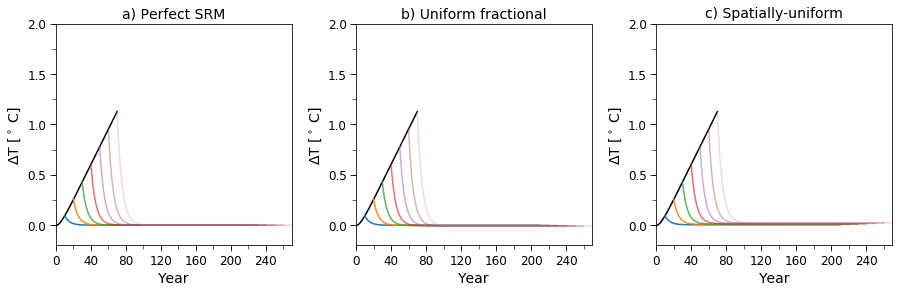

In [19]:
#For plotting the forced part
time = np.arange( 0., 71, 1)
forced = np.trapz( np.mean(sols, axis = 1) * cos_lat[np.newaxis, :], lat * np.pi / 180., axis = 1) / 2.
forced -= 273.15 + np.trapz( con2 * cos_lat[:], lat * np.pi / 180.) / 2.

fig = plt.figure( figsize = (14, 4) )
plt.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.13, top = 0.9, hspace = 0.45, wspace = 0.27)


ax = plt.subplot( 1, 3, 1 )
plt.title("a) Perfect SRM", fontsize = 14)

plt.plot( time, forced, 'k')

#Now plot the SRM
time = np.linspace(0., 200., 1000) 
a = np.linspace(0.3, 1., li)
for k in range( li ):
    plt.plot(lims[k] + time, srm_scen[k], alpha = a[li - 1 - k])
    
plt.xlim([0., 270.])
plt.ylim([-0.2, 2.])

majorLocator = MultipleLocator( 0.5 )
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator( 0.25 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$T [$^\circ$ C]", fontsize = 14)
plt.yticks(fontsize = 12)

majorLocator = MultipleLocator( 40 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 20. )

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
plt.xlabel( "Year", fontsize = 14)
plt.xticks(fontsize = 12)

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction ='out')                                                                                          

ax.tick_params(length = 6, which = 'major')
ax.tick_params(length = 4, which = 'minor')


ax = plt.subplot( 1, 3, 2 )
plt.title("b) Uniform fractional", fontsize = 14)

time = np.arange( 0., 71, 1)

plt.plot( time, forced, 'k')

#Now plot the SRM
time = np.linspace(0., 200., 1000) 
for k in range( li ):
    plt.plot(lims[k] + time, frac_scen[k], alpha = a[li - 1 - k])
    
plt.xlim([0., 270.])
plt.ylim([-0.2, 2.])

majorLocator = MultipleLocator( 0.5 )
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator( 0.25 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$T [$^\circ$ C]", fontsize = 14)
plt.yticks(fontsize = 12)

majorLocator = MultipleLocator( 40 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 20. )

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
plt.xlabel( "Year", fontsize = 14)
plt.xticks(fontsize = 12)

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction ='out')                                                                                          

ax.tick_params(length = 6, which = 'major')
ax.tick_params(length = 4, which = 'minor')

ax = plt.subplot( 1, 3, 3 )
plt.title("c) Spatially-uniform", fontsize = 14)

time = np.arange( 0., 71, 1)

plt.plot( time, forced, 'k')

#Now plot the SRM
time = np.linspace(0., 200., 1000) 
for k in range( li ):
    plt.plot(lims[k] + time, spat_scen[k], alpha = a[li - 1 - k])
    
plt.xlim([0., 270.])
plt.ylim([-0.2, 2.])

majorLocator = MultipleLocator( 0.5 )
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator( 0.25 )

ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel( "$\Delta$T [$^\circ$ C]", fontsize = 14)
plt.yticks(fontsize = 12)

majorLocator = MultipleLocator( 40 )
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator( 20. )

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
plt.xlabel( "Year", fontsize = 14)
plt.xticks(fontsize = 12)

ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction ='out')                                                                                          

ax.tick_params(length = 6, which = 'major')
ax.tick_params(length = 4, which = 'minor')

plt.savefig("transient_state_dependence)no_int_feed.pdf")